In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as K
import matplotlib.pyplot as plt
from keract import *
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


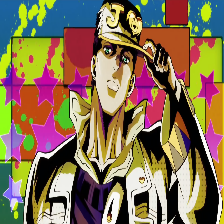

In [2]:
s_image = tf.keras.preprocessing.image.load_img('jojo.png',target_size=(224,224))
s_image

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array

In [4]:
s_image = img_to_array(s_image)
s_image.shape

(224, 224, 3)

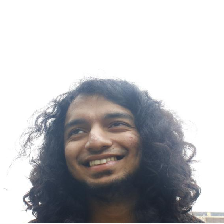

In [5]:
c_image = tf.keras.preprocessing.image.load_img('yashas.png',target_size=(224,224))
c_image

In [6]:
vgg = tf.keras.applications.VGG19(include_top='False', weights='imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
vgg.compile(optimizer='adam',loss='categorical_crossentropy')

In [8]:
s_image = np.expand_dims(s_image, axis=0)


In [9]:
acts = get_activations(vgg, tf.keras.applications.vgg19.preprocess_input(s_image))

In [10]:
#display_activations(acts, save=True)

In [11]:
style_layer=['block2_conv1','block3_conv4']
content_layer=['block5_conv1','block5_conv2']

In [12]:
def model_init(layers):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
 
  outputs = [vgg.get_layer(name).output for name in layers]
  model = tf.keras.Model([vgg.input],outputs)
  return model


In [13]:
def gram_matrix(A):
  return tf.linalg.einsum('bijc,bijd->bcd', A, A)


In [14]:
class DefineModel(tf.keras.models.Model):
  def __init__(self,style_layers,content_layer):
    super(DefineModel, self).__init__()
    self.vgg =  model_init(style_layers + content_layer)
    self.style_layers = style_layers
    self.content_layers = content_layer
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
    
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [15]:
style_extractor = model_init(style_layer)
style_outputs = style_extractor(s_image*255)
style_outputs

[<tf.Tensor: id=1597, shape=(1, 112, 112, 128), dtype=float32, numpy=
 array([[[[5.60206116e+02, 0.00000000e+00, 0.00000000e+00, ...,
           2.79163477e+04, 0.00000000e+00, 8.54729531e+04],
          [4.70876709e+03, 0.00000000e+00, 0.00000000e+00, ...,
           1.40420625e+04, 5.84158057e+03, 5.33441699e+03],
          [5.76392236e+03, 0.00000000e+00, 0.00000000e+00, ...,
           1.39438584e+04, 6.29785010e+03, 7.51802051e+03],
          ...,
          [2.35720483e+03, 0.00000000e+00, 0.00000000e+00, ...,
           1.75950215e+04, 1.10124541e+04, 0.00000000e+00],
          [2.88662817e+03, 0.00000000e+00, 0.00000000e+00, ...,
           2.37897676e+04, 3.67096045e+03, 6.38961182e+03],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           3.80812148e+04, 3.63754023e+04, 0.00000000e+00]],
 
         [[1.70500449e+04, 0.00000000e+00, 0.00000000e+00, ...,
           3.52705508e+04, 0.00000000e+00, 1.07372430e+05],
          [3.18420234e+04, 0.00000000e+00, 0

In [16]:
extractor = DefineModel(style_layer, content_layer)

results = extractor(tf.constant([np.array(c_image)], dtype='float32'))

In [17]:
c_image = tf.constant([np.array(c_image)], dtype='float32')
s_image = tf.constant(np.array(s_image), dtype='float32')
print(c_image)
print(s_image)

tf.Tensor(
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [183. 177. 171.]
   [187. 181. 175.]
   [186. 180. 174.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [186. 181. 175.]
   [187. 182. 176.]
   [185. 180. 174.]]

  [[254. 254. 253.]
   [254. 254. 253.]
   [254. 254. 253.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]], shape=(1, 224, 224, 3), dtype=float32)
tf.Tensor(
[[[[-90.68     -19.779     51.060997]
   [-90.68     -19.779     51.060997]
   [-92.68     -18.779     51.060997]
   ...
   [-93.68     -17.779     51.06099

In [18]:
style_targets = extractor(s_image)['style']
content_targets = extractor(c_image)['content']

In [19]:
generated_image = tf.Variable(c_image)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #LR changed - paper by Khandelwal, changed back to 0.02 as lr > 0.02 distorts image

In [21]:
#Defining Alpha and Beta for weighting costs
style_weight=1e-2 #alpha
content_weight=1e4 #beta
variation_weight = 300


def cost(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight 

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight
    loss = style_loss + content_loss
    return loss


In [22]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = cost(outputs)
    loss += variation_weight * tf.reduce_sum(tf.image.total_variation(image))

  grad = tape.gradient(loss, image) #Finds the derivative d(loss)/dimage
  opt.apply_gradients([(grad, image)]) #Updated the image with the gradients

In [23]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
    tensor = tensor[0]
    return Image.fromarray(tensor)

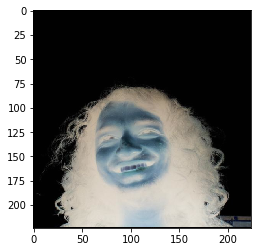

In [24]:
plt.imshow(tensor_to_image(generated_image))

10Number of epochs done.
20Number of epochs done.
50Number of epochs done.
100Number of epochs done.
250Number of epochs done.


KeyboardInterrupt: 

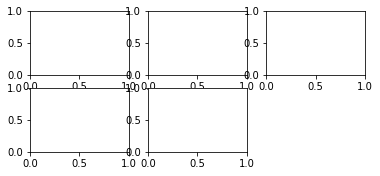

In [26]:
epoch_dict={1:10,2:20,3:50,4:100,5:250,6:500,7:1000,8:1500,9:2500}
import time

start = time.time()
generated_image=tf.Variable(c_image)
key = 1
for i in range(1,2501):
    train_step(generated_image)
    if(i in epoch_dict.values()):
        print(str(i)+"Number of epochs done.")
        plt.subplot(3,3,(key))
        #plt.imshow(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
        tensor_to_image(generated_image).save('./Epoch '+str(key)+'.jpg')
        key +=1
print("Time taken: "+str((time.time()-start)/60))

In [ ]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(c_image), tf.constant(s_image))[0]
tensor_to_image(stylized_image)